# Read normalisation using ERCC RNA Spike-In Mix

In [2]:
import pandas as pd
from scipy import constants
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In this notebook we try and implement transcript quantification using the added mRNA standards.
We will use a modified version of the read normalisation protocol described in [this paper](https://www.frontiersin.org/articles/10.3389/fmars.2022.867007/full). 

We'll use this normalisation approach:

$$Copies_i\:L^{-1} = reads_{i,j} *\frac{spike\:copies_{j}}{spike\:reads_{j}} * \frac{1}{volume\:filtered_{j} * \frac{mL\:used\:for\:RNA\:extraction_{j}}{elution\:volume_{j}}}$$

- Reads<sub>i,j</sub> =  TPM counts for read i in sample j. These already account for transcript length bias.
- Spike copies<sub>j</sub> = The number of ERCC copies that were added to sample j
- Spike reads<sub>j</sub> = The number of TPM read counts associated with the mRNA standards
- Volume filtered<sub>j</sub> = The total L of seawater filtered for sample j
- mL used for RNA extraction<sub>j</sub> = The amount of eluate used for RNA extraction. This is variable due to variations in biomass to keep the extraction protocol as optimal as possible.
- Elution volume<sub>j</sub> = The residue on the inox sieve after the seawater filtration is re-eluted to be flash frozen. The re-elution volume also varied with variations in biomass.

We will calculate normalised reads using a step-by-step approach. First, we'll calculate the ERCC normalisation factor. Then, we will calculate the dilution factor. Last, we will transform the salmon TPM reads accordingly and generate normalised reads per L of seawater.


*Note* Can you really do the last bit, where you multiply the 1 / volume filtered ratio with the mL used for RNA extration divided by elution volume? Because this will scale for the amount of biomassa sampled, but in the library preparation we always departed from 100 ng of RNA extracted. So this factor will only influence how many cells had their RNA extracted. 

Another point of view is however that the amount of the elution of cells used for RNA extraction skews the amount of volume that was filtered in the first place.
Brood a bit on this!

## Data preparation & Regression

In [3]:
# Read in the data
counts_ERCC = pd.read_csv('../../data/ERCC92/kallisto/tpm.csv',index_col = 0)
lab_info = pd.read_csv('../../data/ERCC92/sampling_RNA_Spike_LibPrep.csv', decimal=',', sep=';', encoding='unicode_escape')
meta_ERCC = pd.read_table('../../data/ERCC92/ERCC_Controls_Analysis.txt')

In [4]:
counts_ERCC.head()

,B_120_S11,5_120_S50,A_780_S3,5_130_S45,C_ZG02_S17,C_780_S15,2_700_S37,4_120_S44,2_120_S40,E_330_S22,...,C_130_S13,A_120_S5,A_700_S4,B_330_S8,F_700_S26,E_ZG02_S24,7_130_S57,E_130_S19,1_ZG02_S35,B_780_S9
target_id,,,,,,,,,,,,,,,,,,,,,
ERCC-00002,118593.00,129855.00000,121554.0000,143208.00000,115668.00,116555.00,126790.00000,140772.00,129542.00000,120865.00000,...,113458.00,119650.00000,124320.00000,115169.000000,112534.00,118516.000000,120550.00000,112204.00000,142328.00000,114203.0000
ERCC-00003,8998.19,7776.39000,9291.4600,7243.76000,9181.86,9987.66,8351.46000,7919.04,8769.32000,9108.57000,...,10195.90,9343.01000,9215.03000,10246.000000,10638.90,9212.110000,8430.52000,9676.65000,7273.28000,10377.6000
ERCC-00004,90430.60,71125.30000,88518.1000,65978.00000,89829.20,94661.70,75792.00000,68858.10,76367.50000,86011.60000,...,97226.20,91008.00000,88621.30000,101045.000000,103595.00,90609.900000,85489.40000,91873.30000,66283.30000,102716.0000
ERCC-00009,5604.79,6086.42000,5735.3500,6564.73000,5556.19,5559.89,5988.77000,6687.58,5917.82000,5738.56000,...,5311.15,5574.35000,5521.36000,5327.440000,5468.08,5606.540000,5730.02000,5626.22000,6316.65000,5222.6000
ERCC-00012,0.00,2.55963,2.1136,1.25018,0.00,0.00,1.85724,0.00,2.73227,2.13478,...,0.00,5.28909,1.76281,0.964424,0.00,0.981717,3.09483,1.62108,3.12863,2.3524


In [5]:
lab_info.head()

,Sample,sample_ID,SW_filtered,eluate_volume_mL,rna_extraction_vol_mL,RNA_conc_ng_µl,µl_RNA_used _for_start_LP,pre_dil,ng_RNA_used_for_start_LP,µl_ERCC_spike_1_1000
0,1,A_130_S1,50.0,18.0,1.5,109.7,1.82,1.0,200.0,4.0
1,2,A_330_S2,50.0,18.0,6.0,354.0,1.13,2.0,200.0,4.0
2,3,A_780_S3,50.0,18.0,6.0,407.6,0.98,2.0,200.0,4.0
3,4,A_700_S4,50.0,18.0,6.0,652.0,0.61,2.0,200.0,4.0
4,5,A_120_S5,50.0,18.0,6.0,366.2,1.09,2.0,200.0,4.0


In [6]:
meta_ERCC.head()

,Re-sort ID,ERCC_ID,subgroup,concentration_Mix_1,concentration_Mix_2,expected_fold_change ratio,log2_Mix_1_Mix_2
0,1,ERCC-00130,A,30000.00,7500.0000,4.0,2.0
1,2,ERCC-00004,A,7500.00,1875.0000,4.0,2.0
2,3,ERCC-00136,A,1875.00,468.7500,4.0,2.0
3,4,ERCC-00108,A,937.50,234.3750,4.0,2.0
4,5,ERCC-00116,A,468.75,117.1875,4.0,2.0


In [7]:
# Compare length of both df to spot irregularities
print(f'ERCC TPM count length:{len(counts_ERCC)}, Meta length:{len(meta_ERCC)}')

ERCC TPM count length:92, Meta length:92


## Expression vs variance

In [8]:
# Extract the squared coefficient of variance from each row
coeff_var = (np.std(counts_ERCC, axis=1) / np.mean(counts_ERCC, axis=1)) ** 2
# Extract the mean expression from each row
mean_expression = np.mean(counts_ERCC, axis=1)

In [9]:
# Combine both values in a dataframe
df = pd.DataFrame()
df['CV2'] = coeff_var
df['CV'] = np.sqrt(coeff_var)
df['mean_expression'] = mean_expression
df['log_mean_expression'] = np.log10(mean_expression + 1)

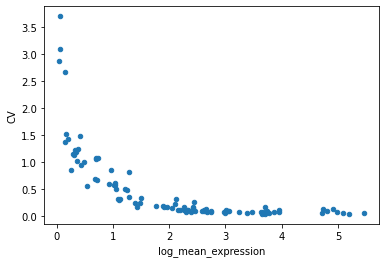

In [10]:
df.plot('log_mean_expression', 'CV', kind='scatter', alpha=1);

This is as expected: transcripts with higher concentrations added to samples have lower coefficients of variance. 

## Detection of expression

In [11]:
# Melt the count dataframe to long format
counts_ERCC = counts_ERCC.reset_index().melt(id_vars=['target_id'], var_name=['sample_ID'], value_name='TPM')
# Join both df together
counts_ERCC = counts_ERCC.merge(meta_ERCC, left_on='target_id', right_on='ERCC_ID')
# Drop irrelevant columns
counts_ERCC = counts_ERCC.drop(columns=['target_id', 'Re-sort ID', 'subgroup', 'concentration_Mix_2', 'expected_fold_change ratio', 'log2_Mix_1_Mix_2'])
# Add how much spike mix was added
counts_ERCC = counts_ERCC.merge(lab_info[['sample_ID', 'µl_ERCC_spike_1_1000']], left_on='sample_ID', right_on='sample_ID')

counts_ERCC.head()

,sample_ID,TPM,ERCC_ID,concentration_Mix_1,µl_ERCC_spike_1_1000
0,B_120_S11,118593.00,ERCC-00002,15000.000000,4.0
1,B_120_S11,8998.19,ERCC-00003,937.500000,4.0
2,B_120_S11,90430.60,ERCC-00004,7500.000000,4.0
3,B_120_S11,5604.79,ERCC-00009,937.500000,4.0
4,B_120_S11,0.00,ERCC-00012,0.114441,4.0


Before data analysis, it is often convenient to transform the spike mix concentration values to reflect the dilution scheme used when adding the samples. For example, if 2 μL of a 1:100 dilution of Spike-In Mix was added to 1 μg of total RNA, multiply the mix concentration column by 0.02 to give new concentration values, expressed as attomoles of ERCC transcript/1 μg total RNA. The concentration values can be expressed in terms of absolute number by conversion of moles to molecules with  Avogadro's number (N
A; 6.02214179 ✕ 10<sup>23</sup> mol<sup>–1</sup>).

At nucleomics, they used 4 µL of a 1/1000 dilution of Spike-In Mix to 200 ng of RNA. When less total RNA was available, less Spike-In Mix was used to maintain the ratio of 0.02. 
So to calculate back to attomoles of ERCC transcript/200 ng total RNA we need to multiply the mix concentration with the amount of µL ERCC mix that was added divided by 1000. 
Now we have the number of molecules -or copies- of every ERCC transcript that was added to each sample, and we will compare this with the TPM values that were recovered.

In [12]:
# Add transformed concentration column to reflect the amount of moles spike added which also incorporates wet lab dilution
counts_ERCC['attomoles_in_total_RNA'] = counts_ERCC['concentration_Mix_1'] * (counts_ERCC['µl_ERCC_spike_1_1000'] / 1000)

# Calculate absolute number of molecules per sample using Avogadro's number, but first we need to converse attomoles to moles (atto = 10^-18) 
counts_ERCC['ERCC_copies'] = counts_ERCC['attomoles_in_total_RNA'] * 10**-18 *constants.Avogadro

In [13]:
counts_ERCC.describe()

,TPM,concentration_Mix_1,µl_ERCC_spike_1_1000,attomoles_in_total_RNA,ERCC_copies
count,5704.000000,5704.000000,5704.000000,5704.000000,5.704000e+03
mean,10869.566004,1125.163358,3.773065,4.245314,2.556588e+06
std,38979.028150,4125.042020,0.672360,15.827286,9.531415e+06
min,0.000000,0.014305,1.090000,0.000016,9.390072e+00
25%,5.181027,0.801086,4.000000,0.001831,1.102687e+03
50%,124.323000,7.324219,4.000000,0.029297,1.764299e+04
75%,1051.000000,117.187500,4.000000,0.468750,2.822878e+05
max,313449.000000,30000.000000,4.000000,120.000000,7.226569e+07


In [14]:
counts_ERCC.sort_values(by='ERCC_copies', ascending=True).head(n=15)

,sample_ID,TPM,ERCC_ID,concentration_Mix_1,µl_ERCC_spike_1_1000,attomoles_in_total_RNA,ERCC_copies
4349,4_330_S42,0.0,ERCC-00048,0.014305,1.09,0.000016,9.390072
4353,4_330_S42,0.0,ERCC-00057,0.014305,1.09,0.000016,9.390072
4364,4_330_S42,0.0,ERCC-00075,0.014305,1.09,0.000016,9.390072
5192,F_700_S26,0.0,ERCC-00075,0.014305,1.30,0.000019,11.199168
5177,F_700_S26,0.0,ERCC-00048,0.014305,1.30,0.000019,11.199168
...,...,...,...,...,...,...,...
949,F_130_S25,0.0,ERCC-00057,0.014305,1.93,0.000028,16.626457
960,F_130_S25,0.0,ERCC-00075,0.014305,1.93,0.000028,16.626457
4370,4_330_S42,0.0,ERCC-00083,0.028610,1.09,0.000031,18.780137
592,2_700_S37,0.0,ERCC-00075,0.014305,2.30,0.000033,19.813913


Now we're interested in the average number of reads we get for a given number of molecules added. What we want to check first is whether TPM increases linearly with the increasing concentrations of ERCC transcripts that were added. **Note**: the concentration increases logarithmically of ERCC spikes, so we need to logtransform TPM and concentration values first. 

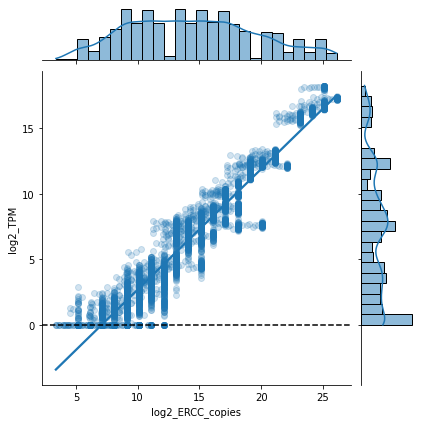

In [15]:
plotdata = counts_ERCC[['ERCC_copies', 'TPM']].copy()
# Add a pseudocount to avoid trying to get log 0
plotdata['ERCC_copies'] = np.log2(plotdata['ERCC_copies'] +1)
plotdata['TPM'] = np.log2(plotdata['TPM'] + 1)
plotdata.columns = ['log2_ERCC_copies', 'log2_TPM']

# Plot the data
plot = sns.jointplot(data=plotdata,
            x='log2_ERCC_copies',
            y='log2_TPM',
            kind='reg',
            joint_kws = {'scatter_kws':dict(alpha=0.2)}
)

# Add horizontal line at 0
plot.ax_joint.axhline(0, color='black', linestyle='--')
plt.show()

# Save the plot as a svg
plot.savefig('../../figures/assembly/ERCC92_TPM_vs_copies.svg')

### The lower limit of detection

There seems to be a linear relationship, great! The dynamic range of the gene expression data seems to be around 18 log units of concentration. Let's calculate how many molecules we need to detect 1 TPM, which is the X-axis value where the sensitivity threshold of 1 TPM (log2 TPM = 0) intersects the linear regression line.

In [15]:
# Regression model
X = np.array(plotdata['log2_ERCC_copies']).reshape(-1, 1)
y = np.array(plotdata['log2_TPM']).reshape(-1, 1)

# Separating the data into independent and dependent variables
# Converting each dataframe into a numpy array
# since each dataframe contains only one column


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Splitting the data into training and testing data
regr = LinearRegression()

regr.fit(X_train, y_train)
print(f'R2: {regr.score(X_test, y_test)}')


R2: 0.931980934547781


We have a good-fitting regression model! Let's obtain the model parameters

In [16]:
intercept = regr.intercept_
coeff = regr.coef_

In [17]:
print(f'Intercept: {intercept}')
print(f'Coefficient: {coeff}')

Intercept: [-6.52059815]
Coefficient: [[0.92072334]]


In [18]:
intercept / coeff

array([[-7.08203853]])

The model is:

$$ log2(TPM) = -6.490 + 0.919 * log2(ERCC\:transcript\:molecules) $$

This means that for the sensitivy threshold of 1 TPM, we need +- 7 log2 molecules of ERCC transcript to be detected. This equals 128 molecules of ERCC transcript per 100 g total RNA.

## The ERCC normalisation factor

First let's verify some numbers.

In [19]:
mean_TPM = counts_ERCC['TPM'].mean()
mean_copies = counts_ERCC['ERCC_copies'].mean()
print(f'The average TPM count: {mean_TPM}')
print(f'The average number of ERCC copies added to a sample: {mean_copies}')
median_TPM = counts_ERCC['TPM'].median()
median_copies = counts_ERCC['ERCC_copies'].median()
print(f'The median TPM count: {median_TPM}')
print(f'The median number of transcript copies added to a sample: {median_copies}')
print(f'On average, 1 TPM equals {mean_copies/mean_TPM} copies')

The average TPM count: 10869.566003512973
The average number of ERCC copies added to a sample: 2556587.812695259
The median TPM count: 124.32300000000001
The median number of transcript copies added to a sample: 17642.9905078125
On average, 1 TPM equals 235.20606175711032 copies


Now we'll calculate the ERCC normalisation factor. This is per sample, the amount of TPM counts for the amount of ERCC transcripts that were added to the sample.

In [20]:
# First remove the rows with TPM counts equalling zero
counts_ERCC = counts_ERCC[counts_ERCC['TPM'] > 0]
counts_ERCC['ERCC_norm_factor'] = counts_ERCC['ERCC_copies'] / counts_ERCC['TPM']

[None]

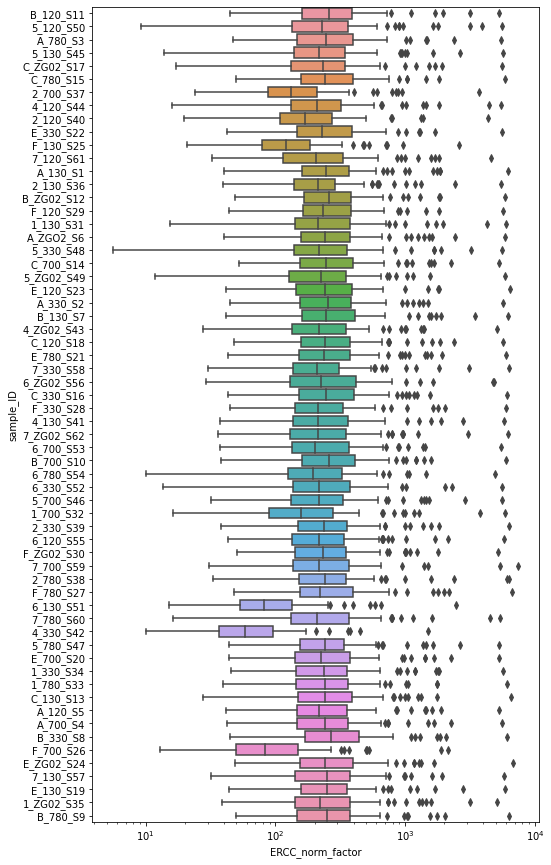

In [21]:
# Let's check per sample the recovery of all ERCC
plt.figure(figsize=(8,15))
ax =sns.boxplot(x='ERCC_norm_factor', y='sample_ID', data=counts_ERCC)
ax.set(xscale='log')

In [22]:
# Group all ERCCs together per sample and take the average recovery
ERCC_normalisation = counts_ERCC[['sample_ID', 'ERCC_norm_factor']].groupby('sample_ID').mean().reset_index()
ERCC_normalisation.head()

,sample_ID,ERCC_norm_factor
0,1_130_S31,430.103511
1,1_330_S34,417.477541
2,1_700_S32,332.905906
3,1_780_S33,378.758385
4,1_ZG02_S35,410.956789


## Dilution factor

Here, we'll calculate the second term of the equation:

$$   \frac{1}{volume\:filtered_{j} * \frac{mL\:used\:for\:RNA\:extraction_{j}}{elution\:volume_{j}}}$$

In [23]:
lab_info = lab_info.dropna(how = 'all')
lab_info = lab_info.fillna(1)

In [24]:
lab_info.head()

,Sample,sample_ID,SW_filtered,eluate_volume_mL,rna_extraction_vol_mL,RNA_conc_ng_µl,µl_RNA_used _for_start_LP,pre_dil,ng_RNA_used_for_start_LP,µl_ERCC_spike_1_1000
0,1,A_130_S1,50.0,18.0,1.5,109.7,1.82,1.0,200.0,4.0
1,2,A_330_S2,50.0,18.0,6.0,354.0,1.13,2.0,200.0,4.0
2,3,A_780_S3,50.0,18.0,6.0,407.6,0.98,2.0,200.0,4.0
3,4,A_700_S4,50.0,18.0,6.0,652.0,0.61,2.0,200.0,4.0
4,5,A_120_S5,50.0,18.0,6.0,366.2,1.09,2.0,200.0,4.0


In [25]:
# Merge both first to ensure correct sample order
ERCC_normalisation = ERCC_normalisation.merge(lab_info[['sample_ID', 'SW_filtered', 'rna_extraction_vol_mL','eluate_volume_mL']], left_on='sample_ID', right_on='sample_ID')

In [26]:
ERCC_normalisation['dilution_norm_factor'] = (1 / (ERCC_normalisation['SW_filtered'] * (ERCC_normalisation['rna_extraction_vol_mL'] / ERCC_normalisation['eluate_volume_mL'])))
ERCC_normalisation = ERCC_normalisation.drop(columns=['SW_filtered', 'rna_extraction_vol_mL','eluate_volume_mL'])

<AxesSubplot:xlabel='dilution_norm_factor', ylabel='sample_ID'>

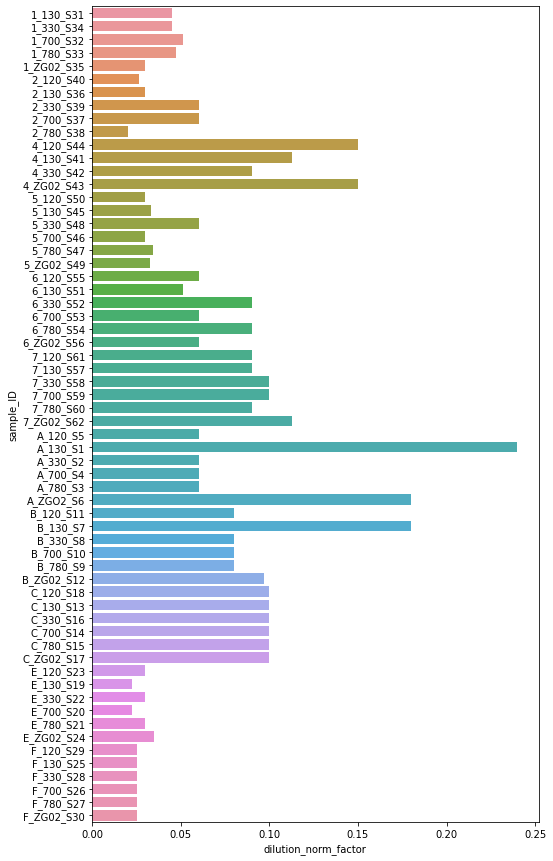

In [27]:
plt.figure(figsize=(8,15))
sns.barplot(x='dilution_norm_factor', y='sample_ID', data=ERCC_normalisation)

## Read normalisation

Save normalisation factors into a csv file, and when handling raw reads one should multiply by these two to get reads per L!

In [28]:
ERCC_normalisation['norm_factor'] = ERCC_normalisation['ERCC_norm_factor'] * ERCC_normalisation['dilution_norm_factor']
#ERCC_normalisation.to_csv('data/normalisation_reads_per_L.csv')
ERCC_normalisation.head()

,sample_ID,ERCC_norm_factor,dilution_norm_factor,norm_factor
0,1_130_S31,430.103511,0.045000,19.354658
1,1_330_S34,417.477541,0.045000,18.786489
2,1_700_S32,332.905906,0.051429,17.120875
3,1_780_S33,378.758385,0.047368,17.941187
4,1_ZG02_S35,410.956789,0.030000,12.328704


<AxesSubplot:xlabel='norm_factor', ylabel='sample_ID'>

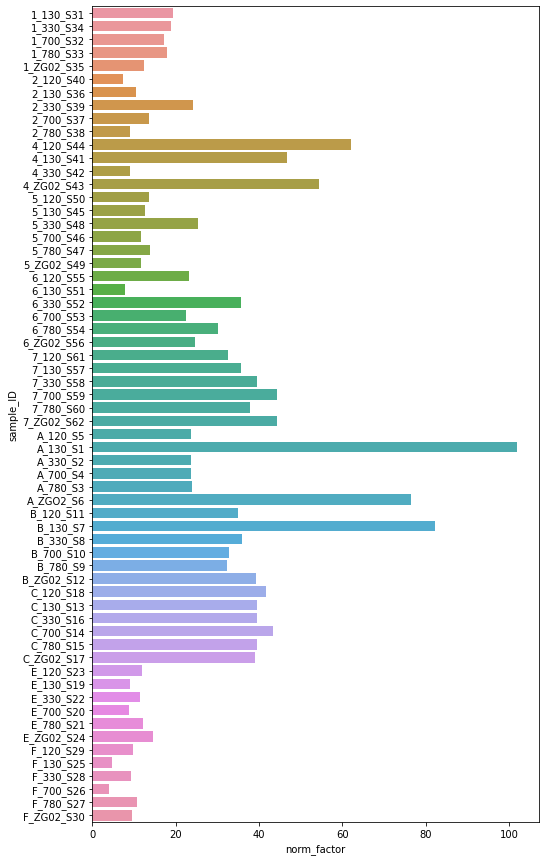

In [29]:
plt.figure(figsize=(8,15))
sns.barplot(x='norm_factor', y='sample_ID', data=ERCC_normalisation)

## Normalisation of TPM values

Now the question is: starting from the TPM counts, how are these best normalized so they can be used in analyses? 
We could use the techniques implemented in EdgeR, or DESeq2, but these are more suited for obtaining differential expression of two closely related ecosystems. Since all samples here are potentially very different, we should implement different normalizations. One could be scaling all samples to unit norm, or scaling to the median TPM value. I'm not sure what the best approach is here, since 0 inflation could have very big effects on the median.

In [30]:
# Preprocess the data
## Set LLD to 1 TPM, all counts below this value are set to 0
data[data < 1] = 0

## Remove rows with all 0 values
data = data.loc[(data!=0).any(axis=1)]

# Preprocess data by scaling features: removing the mean and scale to unit variance.
## This needs the data to be in the format: (samples, features)
## We'll transpose to scale and normalize the data in the correct format
data_scaled = StandardScaler().fit_transform(data.T.to_numpy())
  
# Now, normalize samples by scaling each sample to unit norm.
data_normalized = normalize(data_scaled) 

NameError: name 'data' is not defined

## Transcripts per L

Now we'll use the calculated normalisation factors to create the transcripts per L of seawater dataframe.

In [31]:
gene_expression =  pd.read_csv('../../data/kallisto/tpm.csv', engine='pyarrow')

In [32]:
gene_expression.head()

,target_id,B_120_S11,5_120_S50,A_780_S3,5_130_S45,C_ZG02_S17,C_780_S15,2_700_S37,4_120_S44,2_120_S40,...,C_130_S13,A_120_S5,A_700_S4,B_330_S8,F_700_S26,E_ZG02_S24,7_130_S57,E_130_S19,1_ZG02_S35,B_780_S9
0,c_000000000001,0.233985,0.0,0.0,0.0,0.0,0.776557,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.445188,0.0,0.000000,0.0,0.0
1,c_000000000002,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,c_000000000003,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,c_000000000004,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,c_000000000005,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.204867,0.0,0.0


In [33]:
# Check if all samples are present
gene_expression.shape

(7113509, 63)

In [34]:
# melt the data to long format 
gene_expression = gene_expression.melt(id_vars=['target_id'], var_name=['sample_ID'], value_name='TPM')

In [35]:
gene_expression.head()

,target_id,sample_ID,TPM
0,c_000000000001,B_120_S11,0.233985
1,c_000000000002,B_120_S11,0.000000
2,c_000000000003,B_120_S11,0.000000
3,c_000000000004,B_120_S11,0.000000
4,c_000000000005,B_120_S11,0.000000


In [36]:
# Normalise each transcripts per TPM with the normalisation factor for that sample
gene_expression = gene_expression.merge(ERCC_normalisation[['sample_ID', 'norm_factor']], left_on='sample_ID', right_on='sample_ID', how='outer')
gene_expression['transcripts_per_L'] = gene_expression['TPM'] * gene_expression['norm_factor']

In [37]:
# Transform data to wide format
transcripts_per_L = gene_expression[['target_id', 'sample_ID', 'transcripts_per_L']].pivot(index='target_id', columns='sample_ID', values='transcripts_per_L')

In [38]:
# Check
transcripts_per_L.head()

sample_ID,1_130_S31,1_330_S34,1_700_S32,1_780_S33,1_ZG02_S35,2_120_S40,2_130_S36,2_330_S39,2_700_S37,2_780_S38,...,E_330_S22,E_700_S20,E_780_S21,E_ZG02_S24,F_120_S29,F_130_S25,F_330_S28,F_700_S26,F_780_S27,F_ZG02_S30
target_id,,,,,,,,,,,,,,,,,,,,,
c_000000000001,0.0,19.55279,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,13.722839,0.0,4.452536,6.473213,0.0,0.0,0.0,0.0,7.831663,0.000000
c_000000000002,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.957913,2.053871
c_000000000003,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
c_000000000004,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,4.535230,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
c_000000000005,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,7.987534,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [39]:
# Save the transformed data
transcripts_per_L.to_csv('../../data/kallisto/transcripts_per_L.csv')

In [40]:
# Plot total transcripts per L per month

# Sum spatial samples together per month
july_2020 = ['A_120_S5', 'A_130_S1', 'A_330_S2','A_700_S4', 'A_780_S3', 'A_ZGO2_S6']
august_2020 = ['B_120_S11', 'B_130_S7', 'B_330_S8', 'B_700_S10', 'B_780_S9', 'B_ZG02_S12']
september_2020 = ['C_120_S18','C_130_S13', 'C_330_S16', 'C_700_S14', 'C_780_S15', 'C_ZG02_S17'] 
november_2020 = ['E_120_S23', 'E_130_S19', 'E_330_S22', 'E_700_S20', 'E_780_S21', 'E_ZG02_S24']
december_2020 = ['F_120_S29', 'F_130_S25', 'F_330_S28', 'F_700_S26', 'F_780_S27', 'F_ZG02_S30']
january_2021 =  ['1_130_S31', '1_330_S34', '1_700_S32', '1_780_S33', '1_ZG02_S35']
february_2021 = ['2_120_S40', '2_130_S36', '2_330_S39', '2_700_S37', '2_780_S38']
april_2021 = ['4_120_S44', '4_130_S41', '4_330_S42', '4_ZG02_S43']
may_2021 = ['5_120_S50','5_130_S45', '5_330_S48', '5_700_S46', '5_780_S47', '5_ZG02_S49']
june_2021 = ['6_120_S55', '6_130_S51', '6_330_S52', '6_700_S53', '6_780_S54', '6_ZG02_S56']
july_2021 = ['7_120_S61', '7_130_S57', '7_330_S58', '7_700_S59','7_780_S60', '7_ZG02_S62']

# Sum columns together into new dataframe
transcripts_per_L_monthsum = pd.DataFrame()
transcripts_per_L_monthsum['july_2020'] = transcripts_per_L[july_2020].sum(axis=1)
transcripts_per_L_monthsum['august_2020'] = transcripts_per_L[august_2020].sum(axis=1)
transcripts_per_L_monthsum['september_2020'] = transcripts_per_L[september_2020].sum(axis=1)
transcripts_per_L_monthsum['november_2020'] = transcripts_per_L[november_2020].sum(axis=1)
transcripts_per_L_monthsum['december_2020'] = transcripts_per_L[december_2020].sum(axis=1)
transcripts_per_L_monthsum['january_2021'] = transcripts_per_L[january_2021].sum(axis=1)
transcripts_per_L_monthsum['february_2021'] = transcripts_per_L[february_2021].sum(axis=1)
transcripts_per_L_monthsum['april_2021'] = transcripts_per_L[april_2021].sum(axis=1)
transcripts_per_L_monthsum['may_2021'] = transcripts_per_L[may_2021].sum(axis=1)
transcripts_per_L_monthsum['june_2021'] = transcripts_per_L[june_2021].sum(axis=1)
transcripts_per_L_monthsum['july_2021'] = transcripts_per_L[july_2021].sum(axis=1)

In [41]:
transcripts_per_L_monthsum.head()

,july_2020,august_2020,september_2020,november_2020,december_2020,january_2021,february_2021,april_2021,may_2021,june_2021,july_2021
target_id,,,,,,,,,,,
c_000000000001,0.000000,25.659613,30.637768,24.648589,7.831663,19.55279,0.000000,0.0,0.00000,38.595151,7.491231
c_000000000002,0.000000,8.749391,0.000000,0.000000,4.011784,0.00000,0.000000,0.0,0.00000,35.844848,0.000000
c_000000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.00000,44.995649,0.000000
c_000000000004,0.000000,11.563758,0.000000,4.535230,0.000000,0.00000,0.000000,0.0,0.00000,10.336413,0.000000
c_000000000005,19.337463,17.498781,0.000000,1.851173,0.000000,0.00000,7.987534,0.0,2.48895,29.847108,33.024121


<AxesSubplot:>

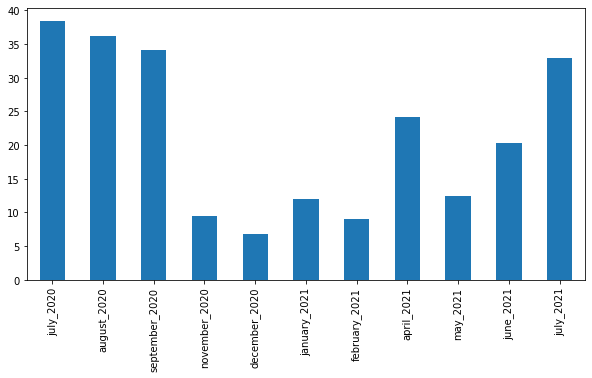

In [42]:
# Plot the average transcripts per L per month
transcripts_per_L_monthsum.mean(axis=0).plot(kind='bar', figsize=(10,5))

# Does the mean vary with the amount of samples per month,
# since we couldn't visit all stations every month?

<AxesSubplot:>

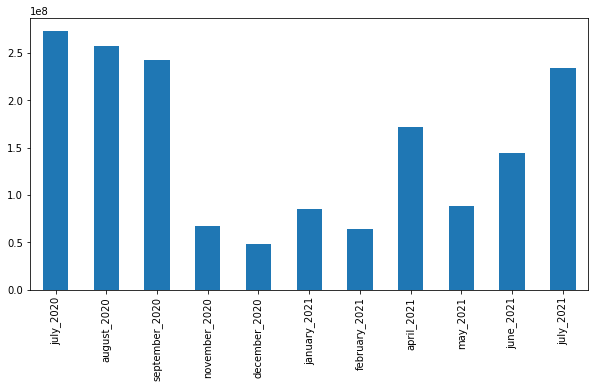

In [45]:
# plot the sum of transcripts per L per month
transcripts_per_L_monthsum.sum(axis=0).plot(kind='bar', figsize=(10,5))

# Beware! The transcript per L sum is dependent on the amount of samples, and not all stations could be visited every month